# Link-level simulations with Sionna RT

In this notebook, you will use ray-traced channels for link-level simulations instead of stochastic channel models

## Background Information

Ray tracing is a technique to simulate environment-specific and physically accurate channel realizations for a given scene and user position. Sionna RT is a ray tracing extension for radio propagation modeling which is built on top of [Mitsuba 3](https://www.mitsuba-renderer.org/). Like all of Sionna's components, it is differentiable.

For an introduction about how to use Sionna RT, please see the [corresponding tutorials](https://nvlabs.github.io/sionna/rt/tutorials.html).
The [EM Primer](https://nvlabs.github.io/sionna/rt/em_primer.html) provides further details on the theoretical background of ray tracing of wireless channels.

In this notebook, we will use Sionna RT for site-specific link-level simulations. For this, we evaluate the BER performance for a MU-MIMO 5G NR system in the uplink direction based on ray traced CIRs for random user positions.

We use the 5G NR PUSCH transmitter and receiver from the [5G NR PUSCH Tutorial notebook](https://nvlabs.github.io/sionna/phy/tutorials/5G_NR_PUSCH.html). Note that also the systems from the MIMO [OFDM Transmissions over the CDL Channel Model](https://nvlabs.github.io/sionna/phy/tutorials/MIMO_OFDM_Transmissions_over_CDL.html) or the [Neural Receiver for OFDM SIMO Systems](https://nvlabs.github.io/sionna/phy/tutorials/Neural_Receiver.html) tutorials could be used instead.

There are different ways to implement uplink scenarios in Sionna RT. In this example, we configure the basestation as transmitter and the user equipments (UEs) as receivers which simplifies the ray tracing. Due to channel reciprocity, one can *reverse* the direction of the ray traced channels afterwards. For the ray tracer itself, the direction (uplink/downlink) does not change the simulated paths.

## Imports

In [1]:
import os # Configure which GPU 
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import or install Sionna
try:
    import sionna.phy
    import sionna.rt
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For link-level simulations
from sionna.phy.channel import OFDMChannel, CIRDataset
from sionna.phy.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.phy.utils import ebnodb2no, PlotBER
from sionna.phy.ofdm import KBestDetector, LinearDetector
from sionna.phy.mimo import StreamManagement

# Import Sionna RT components
from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

## Setting up the Ray Tracer

Let's start by defining some constants that control the system we want to simulate.

In [2]:
# System parameters
subcarrier_spacing = 30e3 # Hz
num_time_steps = 14 # Total number of ofdm symbols per slot

num_tx = 4 # Number of users
num_rx = 1 # Only one receiver considered
num_tx_ant = 4 # Each user has 4 antennas
num_rx_ant = 16 # The receiver is equipped with 16 antennas

# batch_size for CIR generation
batch_size_cir = 1000

We then set up the radio propagation environment. We start by loading a scene and then add a transmitter that acts as a base station. We will later use channel reciprocity to simulate the uplink direction.

In [3]:
# Load an integrated scene.
# You can try other scenes, such as `sionna.rt.scene.etoile`. Note that this would require
# updating the position of the transmitter (see below in this cell).
scene = load_scene(sionna.rt.scene.munich)

# Transmitter (=basestation) has an antenna pattern from 3GPP 38.901
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=num_rx_ant//2, # We want to transmitter to be equiped with 16 antennas
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,21,27],
                 look_at=[45,90,1.5], # optional, defines view direction
                 display_radius=3.) # optinal, radius of the sphere for visualizing the device
scene.add(tx)

# Create new camera
bird_cam = Camera(position=[0,80,500], orientation=np.array([0,np.pi/2,-np.pi/2]))

We then compute a radio map for the instantiated transmitter.

In [4]:
max_depth = 5

# Radio map solver
rm_solver = RadioMapSolver()

# Compute the radio map
rm = rm_solver(scene,
               max_depth=5,
               cell_size=(1., 1.),
               samples_per_tx=10**7)

Let's visualize the computed radio map.

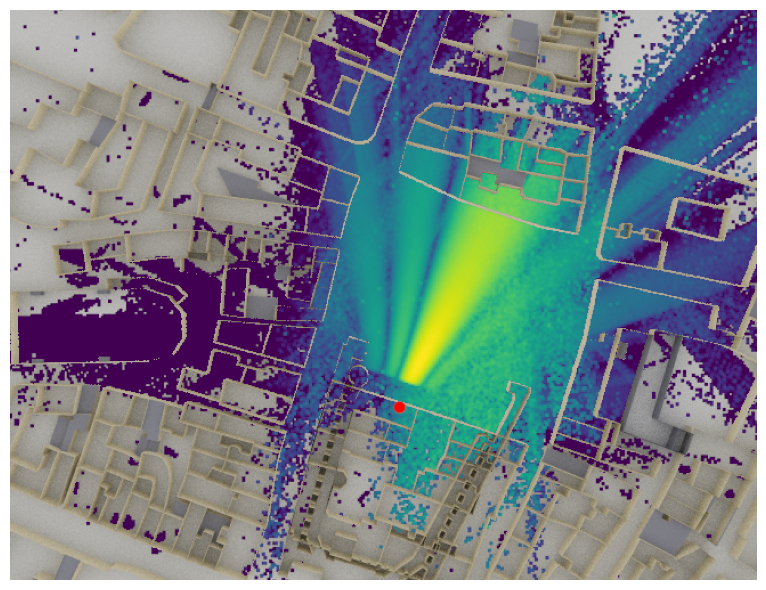

In [5]:
if no_preview:
    # Render an image
    scene.render(camera=bird_cam,
                 radio_map=rm,
                 rm_vmin=-110,
                 clip_at=12.); # Clip the scene at rendering for visualizing the refracted field
else:
    # Show preview
    scene.preview(radio_map=rm,
                  rm_vmin=-110,
                  clip_at=12.); # Clip the scene at rendering for visualizing the refracted field

The function `RadioMap.sample_positions()` allows sampling of random user positions from a radio map. It ensures that only positions that have a path gain of at least `min_gain_dB` dB and at `most max_gain_dB` dB are sampled, i.e., it ignores positions without a connection to the transmitter. Further, one can set the distances `min_dist` and `max_dist` to sample only points within a certain distance range from the transmitter.

In [6]:
min_gain_db = -130 # in dB; ignore any position with less than -130 dB path gain
max_gain_db = 0 # in dB; ignore strong paths

# Sample points in a 5-400m range around the receiver
min_dist = 5 # in m
max_dist = 400 # in m

# Sample batch_size random user positions from the radio map
ue_pos, _ = rm.sample_positions(num_pos=batch_size_cir,
                                metric="path_gain",
                                min_val_db=min_gain_db,
                                max_val_db=max_gain_db,
                                min_dist=min_dist,
                                max_dist=max_dist)

We now add new receivers (=UEs) at the sampled positions.

*Remark:* This is an example for 5G NR PUSCH (uplink direction), we will reverse the direction of the channel for
later BER simulations.

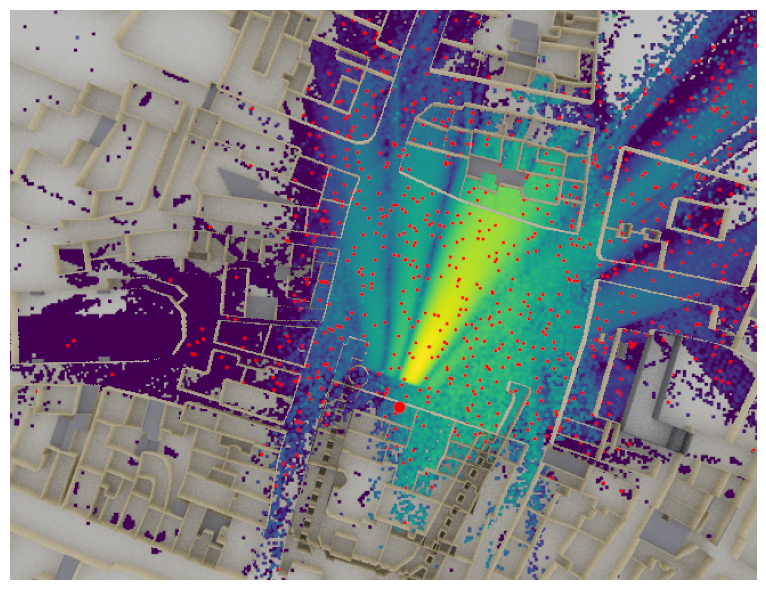

In [7]:
# Configure antenna array for all receivers (=UEs)
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=num_tx_ant//2, # Each receiver is equipped with 4 antennas
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="cross")

# Create batch_size receivers
for i in range(batch_size_cir):
    scene.remove(f"rx-{i}") # Remove old receiver if any
    rx = Receiver(name=f"rx-{i}",
                  position=ue_pos[0][i], # Position sampled from radio map
                  velocity=(3.,3.,0),
                  display_radius=1., # optional, radius of the sphere for visualizing the device
                  color=(1,0,0) # optional, color for visualizing the device
                  )
    scene.add(rx)

# And visualize the scene
if no_preview:
    # Render an image
    scene.render(camera=bird_cam,
                 radio_map=rm,
                 rm_vmin=-110,
                 clip_at=12.); # Clip the scene at rendering for visualizing the refracted field
else:
    # Show preview
    scene.preview(radio_map=rm,
                  rm_vmin=-110,
                  clip_at=12.); # Clip the scene at rendering for visualizing the refracted field

Each dot represents a receiver position drawn from the random sampling function of the radio map.
This allows to efficiently sample batches of random channel realizations even in complex scenarios.

## Creating a CIR Dataset

We can now simulate the CIRs for many different positions which will be used
later on as a dataset for link-level simulations.

*Remark:* Running the cells below can take some time depending on the requested number of CIRs.

In [8]:
target_num_cirs = 5000 # Defines how many different CIRs are generated.
# Remark: some path are removed if no path was found for this position

max_depth = 5
min_gain_db = -130 # in dB / ignore any position with less than -130 dB path gain
max_gain_db = 0 # in dB / ignore any position with more than 0 dB path gain

# Sample points within a 10-400m radius around the transmitter
min_dist = 10 # in m
max_dist = 400 # in m

# List of channel impulse reponses
a_list = []
tau_list = []

# Maximum number of paths over all batches of CIRs.
# This is used later to concatenate all CIRs.
max_num_paths = 0

# Path solver
p_solver = PathSolver()

# Each simulation returns batch_size_cir results
num_runs = int(np.ceil(target_num_cirs/batch_size_cir))
for idx in range(num_runs):
    print(f"Progress: {idx+1}/{num_runs}", end="\r")

    # Sample random user positions
    ue_pos, _ = rm.sample_positions(
                        num_pos=batch_size_cir,
                        metric="path_gain",
                        min_val_db=min_gain_db,
                        max_val_db=max_gain_db,
                        min_dist=min_dist,
                        max_dist=max_dist,
                        seed=idx) # Change the seed from one run to the next to avoid sampling the same positions

    # Update all receiver positions
    for rx in range(batch_size_cir):
        scene.receivers[f"rx-{rx}"].position = ue_pos[0][rx]

    # Simulate CIR
    paths = p_solver(scene, max_depth=max_depth, max_num_paths_per_src=10**7)

    # Transform paths into channel impulse responses
    a, tau = paths.cir(sampling_frequency=subcarrier_spacing,
                         num_time_steps=14,
                         out_type='numpy')
    a_list.append(a)
    tau_list.append(tau)

    # Update maximum number of paths over all batches of CIRs
    num_paths = a.shape[-2]
    if num_paths > max_num_paths:
        max_num_paths = num_paths

# Concatenate all the CIRs into a single tensor along the num_rx dimension.
# First, we need to pad the CIRs to ensure they all have the same number of paths.
a = []
tau = []
for a_,tau_ in zip(a_list, tau_list):
    num_paths = a_.shape[-2]
    a.append(np.pad(a_, [[0,0],[0,0],[0,0],[0,0],[0,max_num_paths-num_paths],[0,0]], constant_values=0))
    tau.append(np.pad(tau_, [[0,0],[0,0],[0,max_num_paths-num_paths]], constant_values=0))
a = np.concatenate(a, axis=0) # Concatenate along the num_rx dimension
tau = np.concatenate(tau, axis=0)

# Let's now convert to uplink direction, by switing the receiver and transmitter
# dimensions
a = np.transpose(a, (2,3,0,1,4,5))
tau = np.transpose(tau, (1,0,2))

# Add a batch_size dimension
a = np.expand_dims(a, axis=0)
tau = np.expand_dims(tau, axis=0)

# Exchange the num_tx and batchsize dimensions
a = np.transpose(a, [3, 1, 2, 0, 4, 5, 6])
tau = np.transpose(tau, [2, 1, 0, 3])

# Remove CIRs that have no active link (i.e., a is all-zero)
p_link = np.sum(np.abs(a)**2, axis=(1,2,3,4,5,6))
a = a[p_link>0.,...]
tau = tau[p_link>0.,...]

print("Shape of a:", a.shape)
print("Shape of tau: ", tau.shape)

Shape of a: (4727, 1, 16, 1, 4, 39, 14)
Shape of tau:  (4727, 1, 1, 39)


Note that transmitters and receivers have been reversed, i.e., the transmitter now denotes the UE (with 4 antennas each) and the receiver is the base station (with 16 antennas).

*Remark:* We have removed all positions for which the resulting CIR had zero gain, i.e., there was no path between the transmitter and the receiver. This comes from the fact that the `RadioMap.sample_positions()` function samples from a radio map subdivided into cells and randomizes the position within the cells. Therefore, randomly sampled positions may have no paths connecting them to the transmitter.

Let us now define a data generator that samples random UEs from the dataset and yields the previously simulated CIRs.

In [9]:
class CIRGenerator:
    """Creates a generator from a given dataset of channel impulse responses

    The generator samples ``num_tx`` different transmitters from the given path
    coefficients `a` and path delays `tau` and stacks the CIRs into a single tensor.

    Note that the generator internally samples ``num_tx`` random transmitters
    from the dataset. For this, the inputs ``a`` and ``tau`` must be given for
    a single transmitter (i.e., ``num_tx`` =1) which will then be stacked
    internally.

    Parameters
    ----------
    a : [batch size, num_rx, num_rx_ant, 1, num_tx_ant, num_paths, num_time_steps], complex
        Path coefficients per transmitter

    tau : [batch size, num_rx, 1, num_paths], float
        Path delays [s] per transmitter

    num_tx : int
        Number of transmitters

    Output
    -------
    a : [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps], tf.complex
        Path coefficients

    tau : [batch size, num_rx, num_tx, num_paths], tf.float
        Path delays [s]
    """

    def __init__(self,
                 a,
                 tau,
                 num_tx):

        # Copy to tensorflow
        self._a = tf.constant(a, tf.complex64)
        self._tau = tf.constant(tau, tf.float32)
        self._dataset_size = self._a.shape[0]

        self._num_tx = num_tx

    def __call__(self):

        # Generator implements an infinite loop that yields new random samples
        while True:
            # Sample 4 random users and stack them together
            idx,_,_ = tf.random.uniform_candidate_sampler(
                            tf.expand_dims(tf.range(self._dataset_size, dtype=tf.int64), axis=0),
                            num_true=self._dataset_size,
                            num_sampled=self._num_tx,
                            unique=True,
                            range_max=self._dataset_size)

            a = tf.gather(self._a, idx)
            tau = tf.gather(self._tau, idx)

            # Transpose to remove batch dimension
            a = tf.transpose(a, (3,1,2,0,4,5,6))
            tau = tf.transpose(tau, (2,1,0,3))

            # And remove batch-dimension
            a = tf.squeeze(a, axis=0)
            tau = tf.squeeze(tau, axis=0)

            yield a, tau

We use Sionna's built-in [CIRDataset](https://nvlabs.github.io/sionna/phy/api/channel.wireless.html#sionna.phy.channel.CIRDataset) to initialize a channel model that can be directly used in Sionna's [OFDMChannel](https://nvlabs.github.io/sionna/phy/api/channel.wireless.html#sionna.phy.channel.OFDMChannel) layer.

In [10]:
batch_size = 20 # Must be the same for the BER simulations as CIRDataset returns fixed batch_size

# Init CIR generator
cir_generator = CIRGenerator(a,
                             tau,
                             num_tx)
# Initialises a channel model that can be directly used by OFDMChannel layer
channel_model = CIRDataset(cir_generator,
                           batch_size,
                           num_rx,
                           num_rx_ant,
                           num_tx,
                           num_tx_ant,
                           max_num_paths,
                           num_time_steps)

## PUSCH Link-Level Simulations

Let's now define an end-to-end model that simulates a PUSCH transmission.

In [11]:
class Model:
    """Simulate PUSCH transmissions

    This model runs BER simulations for a multi-user MIMO uplink channel
    compliant with the 5G NR PUSCH specifications.
    You can pick different scenarios, i.e., channel models, perfect or
    estimated CSI, as well as different MIMO detectors (LMMSE or KBest).

    Parameters
    ----------
    channel_model : :class:`~sionna.channel.ChannelModel` object
        An instance of a :class:`~sionna.channel.ChannelModel` object, such as
        :class:`~sionna.channel.RayleighBlockFading` or
        :class:`~sionna.channel.tr38901.UMi` or
        :class:`~sionna.channel.CIRDataset`.

    perfect_csi : bool
        Determines if perfect CSI is assumed or if the CSI is estimated

    detector : str, one of ["lmmse", "kbest"]
        MIMO detector to be used. Note that each detector has additional
        parameters that can be configured in the source code of the _init_ call.

    Input
    -----
    batch_size : int
        Number of simultaneously simulated slots

    ebno_db : float
        Signal-to-noise-ratio

    Output
    ------
    b : [batch_size, num_tx, tb_size], tf.float
        Transmitted information bits

    b_hat : [batch_size, num_tx, tb_size], tf.float
        Decoded information bits
    """
    def __init__(self,
                 channel_model,
                 perfect_csi, # bool
                 detector,    # "lmmse", "kbest"
                ):
        super().__init__()

        self._channel_model = channel_model
        self._perfect_csi = perfect_csi

        # System configuration
        self._num_prb = 16
        self._mcs_index = 14
        self._num_layers = 1
        self._mcs_table = 1
        self._domain = "freq"

        # Below parameters must equal the Path2CIR parameters
        self._num_tx_ant = 4
        self._num_tx = 4
        self._subcarrier_spacing = 30e3 # must be the same as used for Path2CIR

        # PUSCHConfig for the first transmitter
        pusch_config = PUSCHConfig()
        pusch_config.carrier.subcarrier_spacing = self._subcarrier_spacing/1000
        pusch_config.carrier.n_size_grid = self._num_prb
        pusch_config.num_antenna_ports = self._num_tx_ant
        pusch_config.num_layers = self._num_layers
        pusch_config.precoding = "codebook"
        pusch_config.tpmi = 1
        pusch_config.dmrs.dmrs_port_set = list(range(self._num_layers))
        pusch_config.dmrs.config_type = 1
        pusch_config.dmrs.length = 1
        pusch_config.dmrs.additional_position = 1
        pusch_config.dmrs.num_cdm_groups_without_data = 2
        pusch_config.tb.mcs_index = self._mcs_index
        pusch_config.tb.mcs_table = self._mcs_table

        # Create PUSCHConfigs for the other transmitters by cloning of the first PUSCHConfig
        # and modifying the used DMRS ports.
        pusch_configs = [pusch_config]
        for i in range(1, self._num_tx):
            pc = pusch_config.clone()
            pc.dmrs.dmrs_port_set = list(range(i*self._num_layers, (i+1)*self._num_layers))
            pusch_configs.append(pc)

        # Create PUSCHTransmitter
        self._pusch_transmitter = PUSCHTransmitter(pusch_configs, output_domain=self._domain)

        # Create PUSCHReceiver
        rx_tx_association = np.ones([1, self._num_tx], bool)
        stream_management = StreamManagement(rx_tx_association,
                                             self._num_layers)

        assert detector in["lmmse", "kbest"], "Unsupported MIMO detector"
        if detector=="lmmse":
            detector = LinearDetector(equalizer="lmmse",
                                      output="bit",
                                      demapping_method="maxlog",
                                      resource_grid=self._pusch_transmitter.resource_grid,
                                      stream_management=stream_management,
                                      constellation_type="qam",
                                      num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)
        elif detector=="kbest":
            detector = KBestDetector(output="bit",
                                     num_streams=self._num_tx*self._num_layers,
                                     k=64,
                                     resource_grid=self._pusch_transmitter.resource_grid,
                                     stream_management=stream_management,
                                     constellation_type="qam",
                                     num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)

        if self._perfect_csi:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
                                                 mimo_detector=detector,
                                                 input_domain=self._domain,
                                                 channel_estimator="perfect")
        else:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
                                                 mimo_detector=detector,
                                                 input_domain=self._domain)


        # Configure the actual channel
        self._channel = OFDMChannel(
                            self._channel_model,
                            self._pusch_transmitter.resource_grid,
                            normalize_channel=True,
                            return_channel=True)

    # XLA currently not supported by the CIRDataset function
    @tf.function(jit_compile=False)
    def __call__(self, batch_size, ebno_db):

        x, b = self._pusch_transmitter(batch_size)
        no = ebnodb2no(ebno_db,
                       self._pusch_transmitter._num_bits_per_symbol,
                       self._pusch_transmitter._target_coderate,
                       self._pusch_transmitter.resource_grid)
        y, h = self._channel(x, no)
        if self._perfect_csi:
            b_hat = self._pusch_receiver(y, no, h)
        else:
            b_hat = self._pusch_receiver(y, no)
        return b, b_hat

We now initialize the end-to-end model that uses the `CIRDataset`.

In [12]:
ebno_db = 10.
e2e_model = Model(channel_model,
                  perfect_csi=False, # bool
                  detector="lmmse")  # "lmmse", "kbest" 

# We can draw samples from the end-2-end link-level simulations
b, b_hat = e2e_model(batch_size, ebno_db)

Now, let's run the BER evaluation for different system configurations.

*Remark:* Running the cell below can take some time.

In [13]:
ebno_db = np.arange(-3, 18, 2) # sim SNR range
ber_plot = PlotBER(f"Site-Specific MU-MIMO 5G NR PUSCH")

for detector in ["lmmse", "kbest"]:
    for perf_csi in [True, False]:
        e2e_model = Model(channel_model,
                          perfect_csi=perf_csi,
                          detector=detector)
        # define legend
        csi = "Perf. CSI" if perf_csi else "Imperf. CSI"
        det = "K-Best" if detector=="kbest" else "LMMSE"
        l = det + " " + csi
        ber_plot.simulate(
                    e2e_model,
                    ebno_dbs=ebno_db, # SNR to simulate
                    legend=l, # legend string for plotting
                    max_mc_iter=500,
                    num_target_block_errors=2000,
                    batch_size=batch_size, # batch-size per Monte Carlo run
                    soft_estimates=False, # the model returns hard-estimates
                    early_stop=True,
                    show_fig=False,
                    add_bler=True,
                    forward_keyboard_interrupt=True);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.3210e-01 | 9.5185e-01 |     1424408 |    10782720 |         2056 |        2160 |        23.8 |reached target block errors
     -1.0 | 6.5100e-02 | 5.8488e-01 |     1117934 |    17172480 |         2012 |        3440 |         5.5 |reached target block errors
      1.0 | 3.2190e-02 | 2.7486e-01 |     1169833 |    36341760 |         2001 |        7280 |        11.6 |reached target block errors
      3.0 | 1.8199e-02 | 1.5847e-01 |     1148305 |    63098880 |         2003 |       12640 |        20.1 |reached target block errors
      5.0 | 9.6161e-03 | 8.6979e-02 |     1106003 |   115015680 |         2004 |       23040 |        36.5 |reached target block errors
      7.0 | 4.7417e-03 | 4.3675e-02 |      946815 |   199680000 |

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.4725e-01 | 9.9904e-01 |     1528976 |    10383360 |         2078 |        2080 |        52.4 |reached target block errors
     -1.0 | 7.6806e-02 | 8.5125e-01 |      920195 |    11980800 |         2043 |        2400 |        33.2 |reached target block errors
      1.0 | 3.3255e-02 | 3.3273e-01 |     1009341 |    30351360 |         2023 |        6080 |        83.7 |reached target block errors
      3.0 | 1.5603e-02 | 1.4101e-01 |     1109188 |    71086080 |         2008 |       14240 |       196.6 |reached target block errors
      5.0 | 6.1264e-03 | 5.6948e-02 |     1074081 |   175319040 |         2000 |       35120 |       484.8 |reached target block errors
      7.0 | 1.8097e-03 | 1.9000e-02 |      361368 |   199680000 |

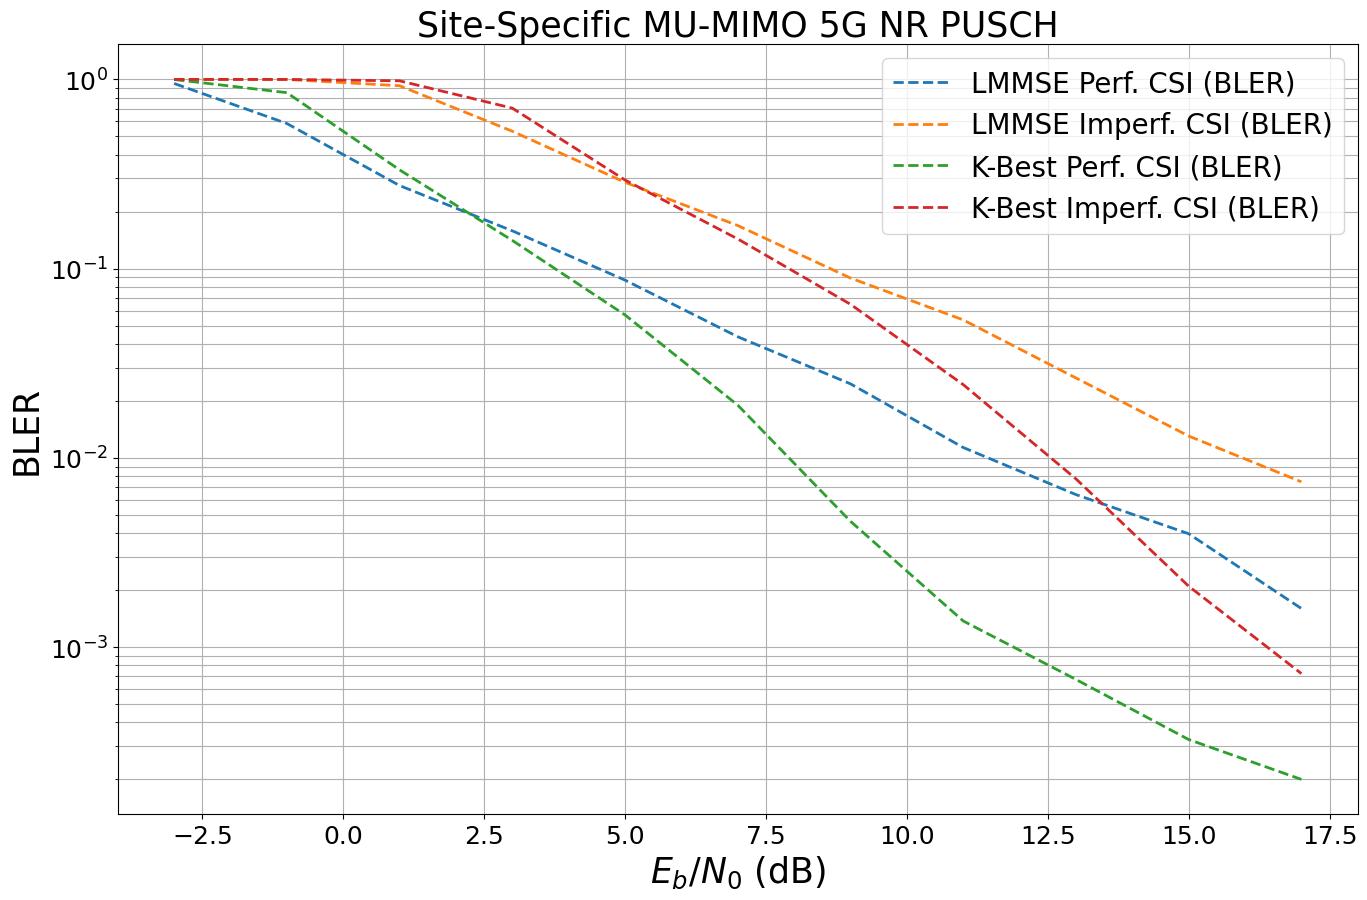

In [14]:
ber_plot(show_ber=False)